<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1068), reused 1085 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 25.82 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79e1397a7f10>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

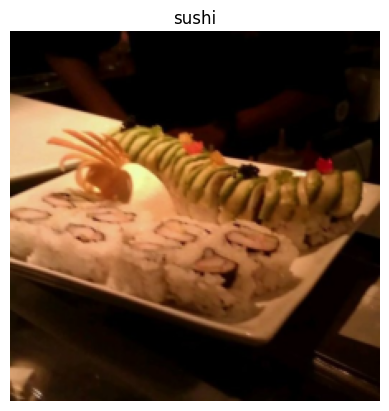

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [10]:
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

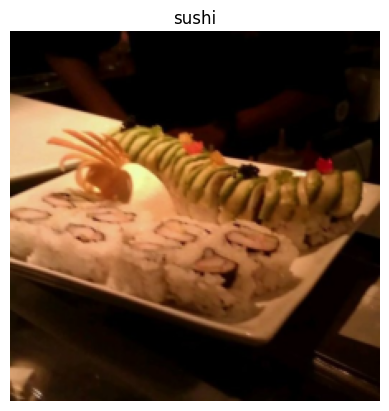

In [12]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

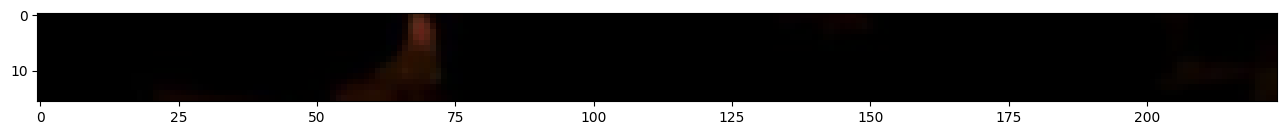

In [13]:
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


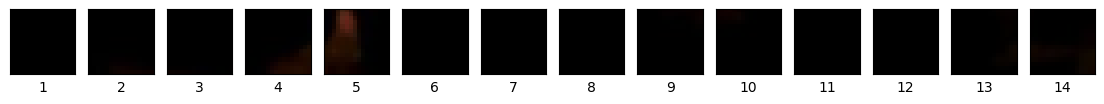

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


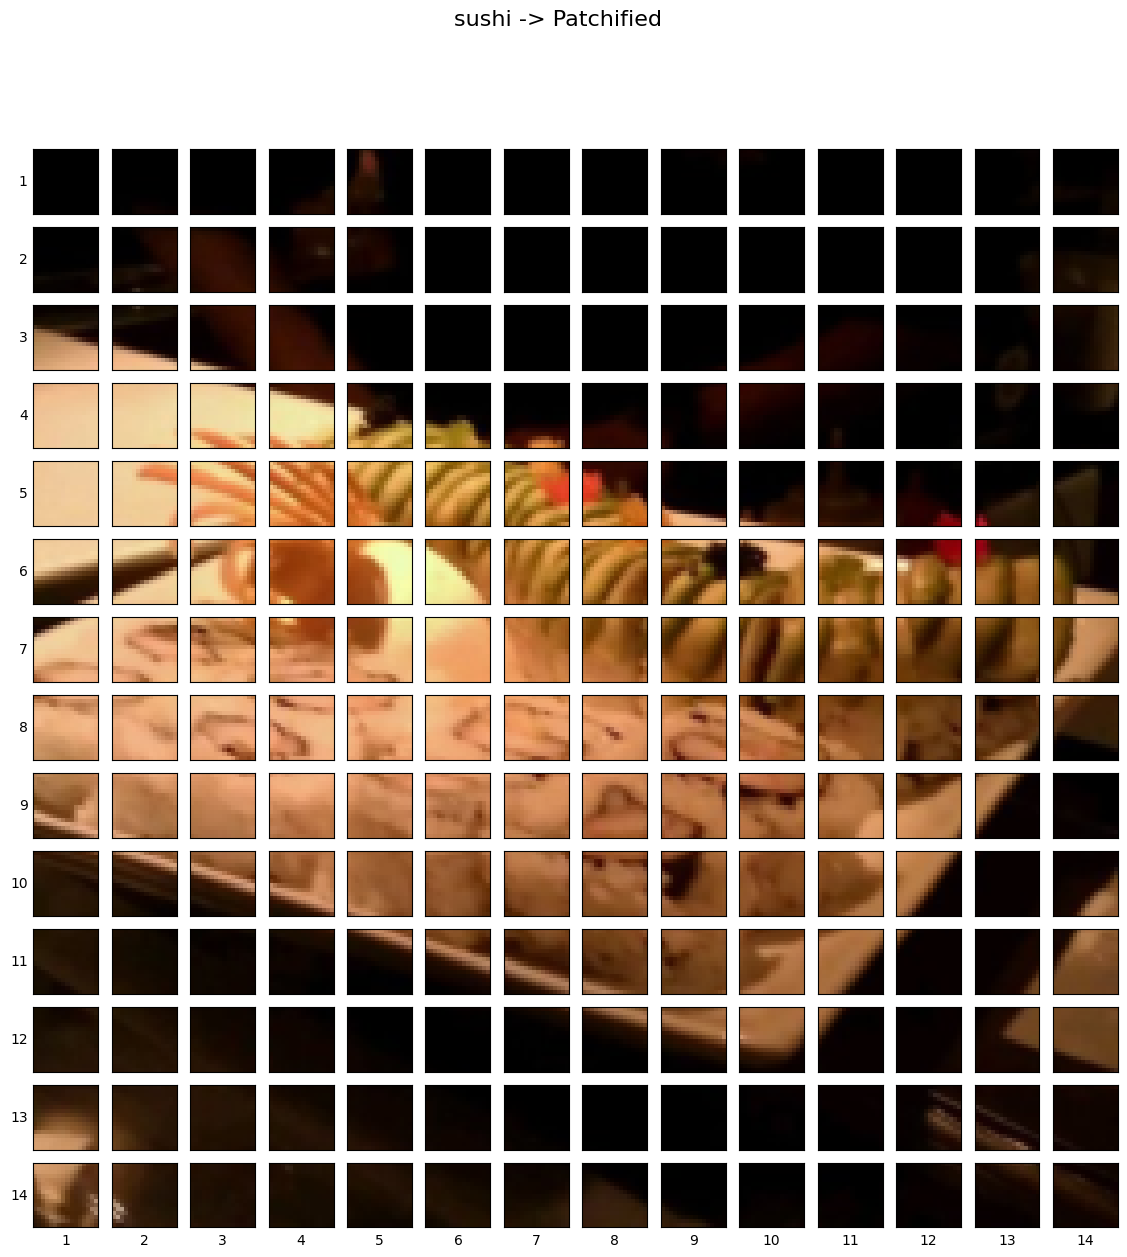

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

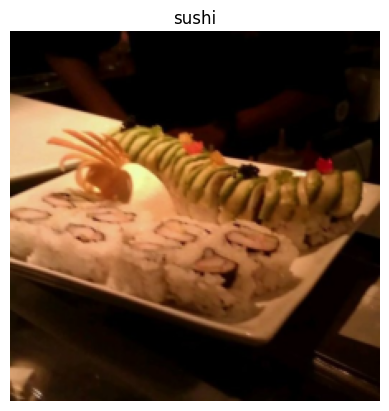

In [17]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image.shape)
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [196, 39, 34, 126, 443]


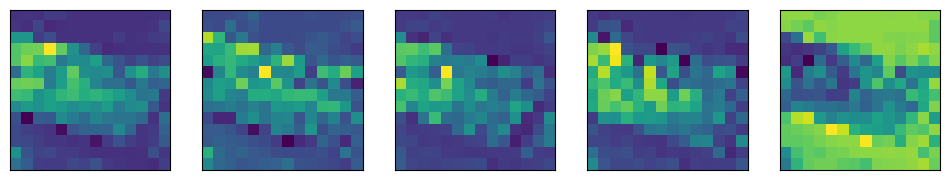

In [19]:
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-6.9941e-04, -2.1518e-03,  1.4510e-03, -1.4332e-02, -1.7327e-02,
           -6.9941e-04, -6.9941e-04, -6.9941e-04, -2.7886e-03,  6.9789e-03,
           -6.9941e-04, -6.9941e-04, -9.4858e-03,  1.5543e-03],
          [-1.2762e-02, -1.9779e-02,  1.8615e-02,  8.9360e-03,  2.9721e-02,
           -6.9941e-04, -6.9941e-04, -6.9941e-04, -6.9941e-04, -6.9941e-04,
           -6.9941e-04, -6.9941e-04, -7.6294e-03, -1.6814e-02],
          [-1.2811e-01, -1.0118e-01, -4.0478e-02,  3.2389e-02,  3.0922e-03,
           -6.9941e-04, -6.9941e-04, -6.9941e-04, -6.3010e-05, -6.7827e-03,
            1.1091e-02,  3.4166e-03, -1.3663e-02, -3.5465e-02],
          [-2.2623e-01, -2.4089e-01, -1.2756e-01, -1.3370e-01, -3.9672e-02,
           -8.1491e-03,  2.9560e-02,  4.0671e-03, -1.4191e-02,  2.5104e-02,
            2.7396e-02,  3.3516e-03, -2.7388e-03, -2.1613e-02],
          [-2.1862e-01, -1.4221e-01, -9.8555e-02,  3.3321e-02, -1.6766e-02,
            3.2107e-02, -1.5475e-02, -5.4678e-02,  1.1779e-0

In [22]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [24]:
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

In [25]:
image.unsqueeze(0)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2157, 0.2549, 0.3490,  ..., 0.0941, 0.1020, 0.1137],
          [0.1843, 0.2118, 0.2667,  ..., 0.0745, 0.0902, 0.0980],
          [0.1608, 0.1882, 0.2314,  ..., 0.0706, 0.0824, 0.0863]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1137, 0.1412, 0.2118,  ..., 0.0275, 0.0353, 0.0431],
          [0.0980, 0.1137, 0.1451,  ..., 0.0078, 0.0235, 0.0314],
          [0.0863, 0.1020, 0.1216,  ..., 0.0078, 0.0118, 0.0196]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [26]:
patch_embedded_image = patchify(image.unsqueeze(0))

In [27]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [28]:
image.shape[-1]

224

In [29]:
224/ 16

14.0

In [30]:
16 * 16 * 3

768

In [31]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

In [32]:
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [33]:
print(patch_embedded_image.shape)


torch.Size([1, 196, 768])


In [34]:
batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]

In [35]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimensions,
                                      requires_grad=True))

In [36]:
print(class_token[:, :, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [37]:
class_token.shape

torch.Size([1, 1, 768])

In [38]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

In [39]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [40]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-1.8767e-02, -1.1375e-02, -3.1134e-02,  ...,  1.0548e-02,
          -3.2569e-03,  3.2575e-03],
         [-2.5466e-02, -1.5416e-02, -3.2189e-02,  ...,  8.1390e-03,
          -7.6404e-03,  1.1814e-02],
         ...,
         [-4.2411e-02,  8.7441e-04, -3.4093e-02,  ...,  2.5235e-02,
          -2.1253e-02, -5.9188e-03],
         [-5.1753e-02,  1.0875e-02, -2.3126e-02,  ...,  4.5551e-02,
          -4.7235e-02, -2.3872e-02],
         [-1.1751e-01, -9.3462e-03, -2.1875e-02,  ...,  3.0708e-02,
          -3.3585e-02, -3.2630e-03]]], grad_fn=<CatBackward0>)

In [41]:
16**2 * 3

768

In [42]:
number_of_patches

196

In [43]:
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
embedding_dimension

768

In [44]:
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

In [45]:
print(position_embedding[:, :10, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [46]:
position_embedding.shape

torch.Size([1, 197, 768])

In [47]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9812, 0.9886, 0.9689,  ..., 1.0105, 0.9967, 1.0033],
         [0.9745, 0.9846, 0.9678,  ..., 1.0081, 0.9924, 1.0118],
         ...,
         [0.9576, 1.0009, 0.9659,  ..., 1.0252, 0.9787, 0.9941],
         [0.9482, 1.0109, 0.9769,  ..., 1.0456, 0.9528, 0.9761],
         [0.8825, 0.9907, 0.9781,  ..., 1.0307, 0.9664, 0.9967]]],
       grad_fn=<AddBackward0>)


In [48]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [49]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [50]:
# Summary

set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,
                                      embedding_dimensions),
                                      requires_grad = True)
print(class_token.shape)

patch_embedding_class_token = torch.cat((class_token, patch_embedded_image), dim = 1)
print(patch_embedding_class_token.shape)


number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [55]:
class MultiheadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dims: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dims)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dims,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)

    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [56]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dims=768, # from Table 1
                                                             num_heads=12) # from Table 1
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(patch_and_position_embedding.shape)
print(patched_image_through_msa_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [51]:
Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb

SyntaxError: ignored